In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('DATA/RSCCASN.csv', parse_dates=True, index_col='DATE')
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [3]:
df.columns = ['sales']
df.tail()

,sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


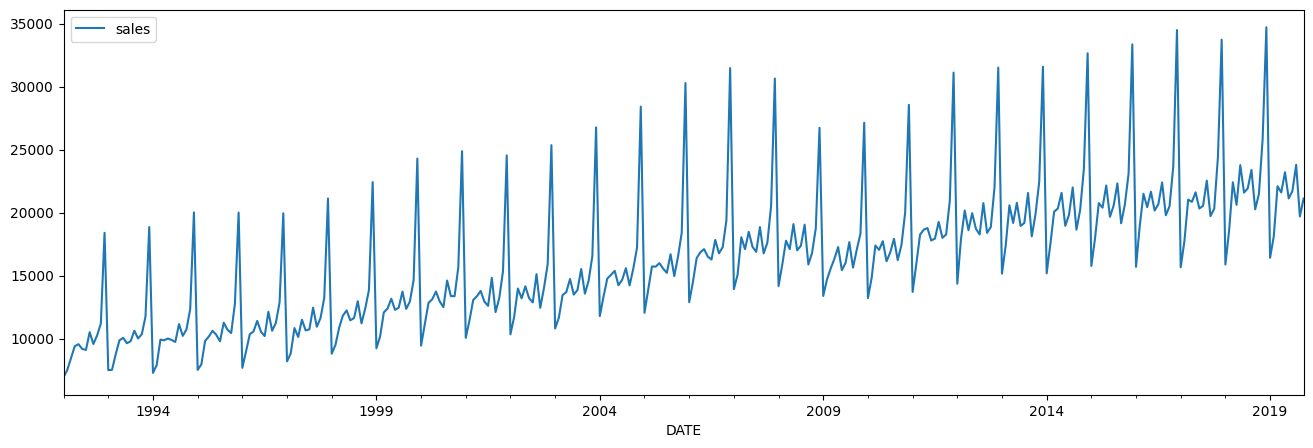

In [4]:
df.plot(figsize=(16,5))
plt.show()

In [5]:
point = len(df)-18
train = df.iloc[:point]
test = df.iloc[point:]

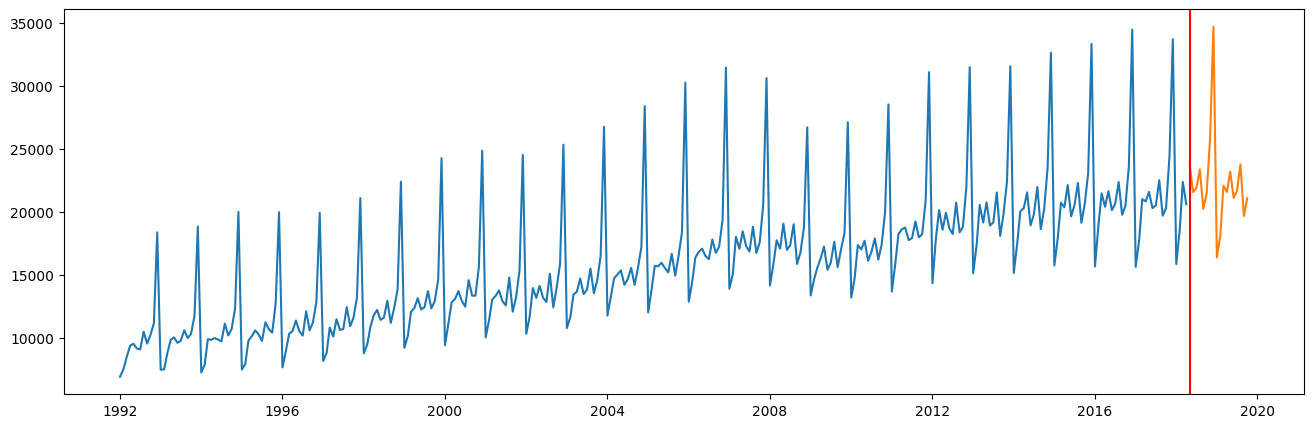

In [6]:
plt.figure(figsize=(16,5))
plt.plot(train.index, train['sales'])
plt.plot(test.index, test['sales'])
plt.axvline(df.index[point], color='red')
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
scale.fit(train)

MinMaxScaler()

In [8]:
scaled_train = scale.transform(train)
scaled_test = scale.transform(test)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=length,
                                batch_size=1)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
n_features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
validation_generator = TimeseriesGenerator(scaled_test,
                                           scaled_test,
                                           length=length,
                                           batch_size=1)

In [14]:
model.fit(generator,
          epochs=20,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 12s 17ms/step - loss: 0.0239 - val_loss: 0.0031
Epoch 2/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0188 - val_loss: 0.0106
Epoch 3/20
304/304 [==============================] - 5s 15ms/step - loss: 0.0151 - val_loss: 0.0181


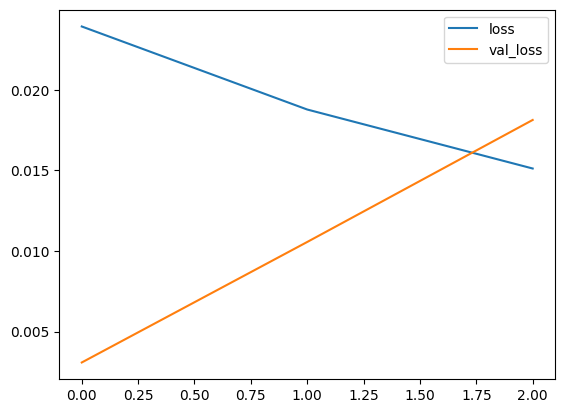

In [15]:
pd.DataFrame(model.history.history).plot()
plt.show()

In [16]:
test_prediction = []

first_evaluation_batch = scaled_train[-length:]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    test_prediction.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis=1)

1/1 [==============================] - 0s 96ms/step


In [17]:
true_prediction = scale.inverse_transform(test_prediction)

In [18]:
test['prediction'] = true_prediction

C:\Users\Sri Maryani\AppData\Local\Temp\ipykernel_7980\2961615516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = true_prediction


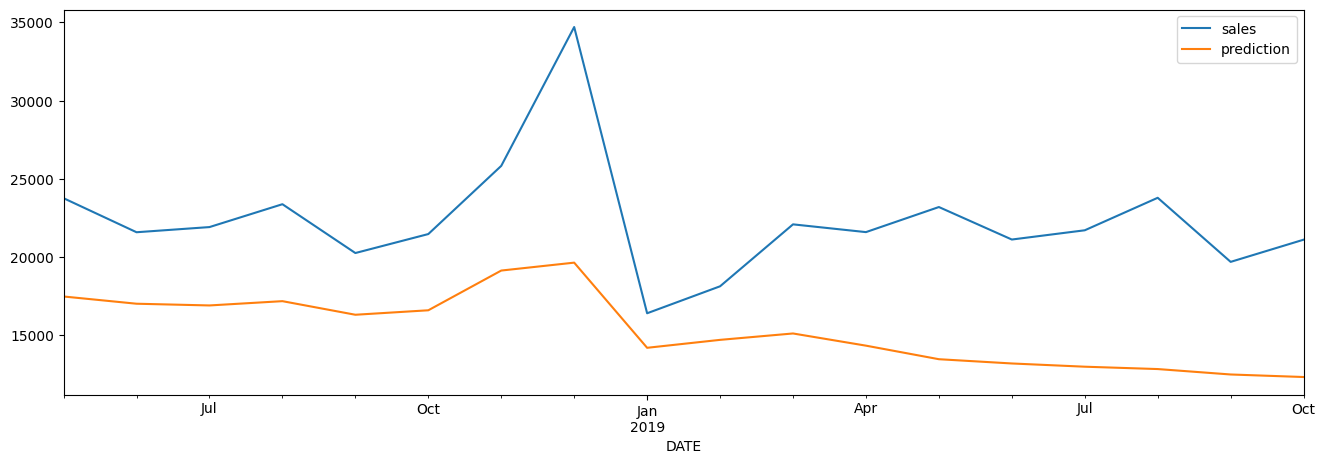

In [19]:
test.plot(figsize=(16,5))
plt.show()

In [20]:
full_scale = MinMaxScaler()
data_scale = full_scale.fit_transform(df)

In [21]:
length = 12
generator = TimeseriesGenerator(data_scale,
                                data_scale,
                                length=length,
                                batch_size=1)

In [22]:
model = Sequential()
model.add(LSTM(100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.fit(generator, epochs=8)

Epoch 1/8
322/322 [==============================] - 14s 17ms/step - loss: 0.0238
Epoch 2/8
322/322 [==============================] - 5s 17ms/step - loss: 0.0200
Epoch 3/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0196
Epoch 4/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0181
Epoch 5/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0175
Epoch 6/8
322/322 [==============================] - 6s 17ms/step - loss: 0.0164
Epoch 7/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0159
Epoch 8/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0152


In [24]:
forecast = []
period = 12

first_eval_batch = data_scale[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

prediction_length = range(50)

for i in range(period):
    current_prediction = model.predict(current_batch)[0]
    forecast.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:],
                              [[current_prediction]],
                              axis=1)

1/1 [==============================] - 0s 56ms/step


In [25]:
forecast = full_scale.inverse_transform(forecast)

In [26]:
forecast_index = pd.date_range(start='2019-11-01', periods=period, freq='MS')

In [27]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [28]:
forecast = pd.DataFrame(data=forecast, index=forecast_index, columns=['sales'])
forecast

,sales
2019-11-01,23604.859990
2019-12-01,23176.569303
2020-01-01,18960.423450
2020-02-01,20349.063771
2020-03-01,21458.643174
2020-04-01,21492.394009
2020-05-01,21644.042709
2020-06-01,21272.803381
2020-07-01,21462.016271
2020-08-01,21498.013080


In [29]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2019-11-01 to 2020-10-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


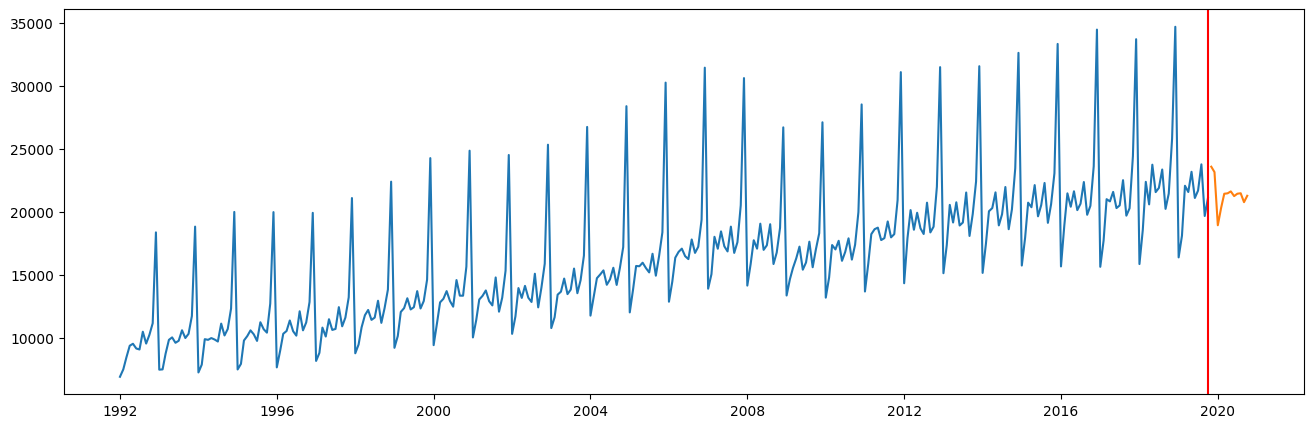

In [30]:
plt.figure(figsize=(16,5))
plt.plot(df.index, df['sales'])
plt.plot(forecast.index, forecast['sales'])
plt.axvline(df.index[-1], color='red')
plt.show()